# KPIs & Metrics
## Day 3 – Performance Evaluation

This notebook focuses on identifying and evaluating the key performance indicators
(KPIs) used to assess the effectiveness of the redesigned digital interface.
The analysis compares the Control and Test groups based on completion rate,
time spent on each step, and error rates.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


In [2]:
DATA_PATH = "../data"

demo = pd.read_csv(f"{DATA_PATH}/df_final_demo.txt")
experiment = pd.read_csv(f"{DATA_PATH}/df_final_experiment_clients.txt")
web_pt1 = pd.read_csv(f"{DATA_PATH}/df_final_web_data_pt_1.txt")
web_pt2 = pd.read_csv(f"{DATA_PATH}/df_final_web_data_pt_2.txt")

In [3]:
web = pd.concat([web_pt1, web_pt2], axis=0)
web['date_time'] = pd.to_datetime(web['date_time'])

df = (
    web
    .merge(experiment, on='client_id', how='inner')
    .merge(demo, on='client_id', how='left')
)

df = df.sort_values(
    by=['client_id', 'visit_id', 'date_time']
)


In [4]:
funnel = (
    df.groupby(['Variation', 'process_step'])['client_id']
    .nunique()
    .reset_index(name='users')
)

funnel


,Variation,process_step,users
0,Control,confirm,15434
1,Control,start,23397
2,Control,step_1,20152
3,Control,step_2,18650
4,Control,step_3,17422
5,Test,confirm,18687
6,Test,start,26679
7,Test,step_1,24267
8,Test,step_2,22258
9,Test,step_3,20881


In [9]:
step_order = ["start", "step_1", "step_2", "step_3", "confirm"]

kpi_base = funnel.pivot(index="Variation", columns="process_step", values="users")
kpi_base = kpi_base.reindex(columns=step_order)

kpi_base


process_step,start,step_1,step_2,step_3,confirm
Variation,,,,,
Control,23397,20152,18650,17422,15434
Test,26679,24267,22258,20881,18687


# KPI 1 – Completion Rate

The completion rate measures the proportion of users who successfully complete
the digital process by reaching the final confirmation step after starting it.


In [12]:
kpi_base["completion_rate"] = kpi_base["confirm"] / kpi_base["start"]

# uplift absoluto (diferencia en puntos porcentuales) y relativo
control_cr = kpi_base.loc["Control", "completion_rate"]
test_cr = kpi_base.loc["Test", "completion_rate"]

uplift_abs = test_cr - control_cr
uplift_rel = (test_cr / control_cr) - 1

pd.DataFrame({
    "completion_rate": kpi_base["completion_rate"],
    "uplift_abs_pp": [np.nan, uplift_abs],   # solo tiene sentido mostrarlo para Test
    "uplift_rel": [np.nan, uplift_rel]
})


,completion_rate,uplift_abs_pp,uplift_rel
Variation,,,
Control,0.659657,NaN,NaN
Test,0.700439,0.040781,0.061822


C:\Users\Mónica\AppData\Local\Temp\ipykernel_5316\1713159927.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


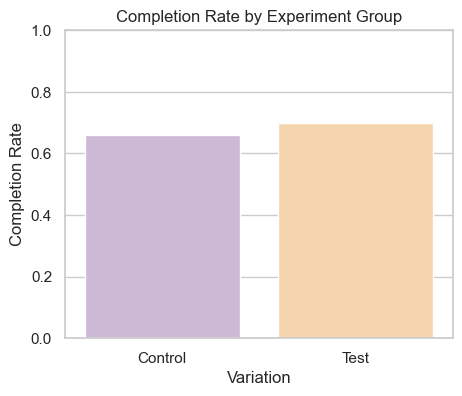

In [13]:
cr_plot = kpi_base["completion_rate"].reset_index()
cr_plot.columns = ["Variation", "completion_rate"]

plt.figure(figsize=(5,4))
sns.barplot(
    data=cr_plot,
    x="Variation",
    y="completion_rate",
    palette={"Control": "#CDB4DB", "Test": "#FFD6A5"}
)
plt.title("Completion Rate by Experiment Group")
plt.ylabel("Completion Rate")
plt.ylim(0, 1)
plt.show()


# **KPI 2 — Time spent on each step**

In [25]:
df_time = df.copy()

df_time["next_time"] = df_time.groupby(
    ["client_id", "visit_id"]
)["date_time"].shift(-1)

df_time["next_step"] = df_time.groupby(
    ["client_id", "visit_id"]
)["process_step"].shift(-1)

df_time["time_spent_sec"] = (
    df_time["next_time"] - df_time["date_time"]
).dt.total_seconds()

# Filtrar tiempos razonables
df_time = df_time[
    (df_time["time_spent_sec"] > 0) &
    (df_time["time_spent_sec"] < 3600)
]

# Definir transiciones válidas del funnel
valid_next = {
    "start": ["step_1"],
    "step_1": ["step_2"],
    "step_2": ["step_3"],
    "step_3": ["confirm"]
}

df_time["valid_transition"] = df_time.apply(
    lambda r: r["next_step"] in valid_next.get(r["process_step"], []),
    axis=1
)

time_kpi = (
    df_time[df_time["valid_transition"]]
    .groupby(["Variation", "process_step"])["time_spent_sec"]
    .mean()
    .reset_index()
)

time_kpi["process_step"] = pd.Categorical(
    time_kpi["process_step"],
    categories=step_order,
    ordered=True
)

time_kpi = time_kpi.sort_values(["Variation", "process_step"])
time_kpi["time_spent_min"] = time_kpi["time_spent_sec"] / 60

time_kpi


,Variation,process_step,time_spent_sec,time_spent_min
0,Control,start,37.641197,0.627353
1,Control,step_1,33.846740,0.564112
2,Control,step_2,87.291152,1.454853
3,Control,step_3,127.919168,2.131986
4,Test,start,30.857455,0.514291
5,Test,step_1,37.144631,0.619077
6,Test,step_2,86.645700,1.444095
7,Test,step_3,104.745162,1.745753


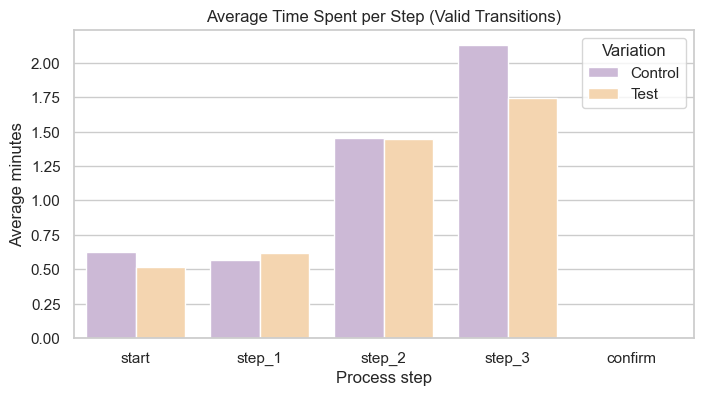

In [27]:
plt.figure(figsize=(8,4))
sns.barplot(
    data=time_kpi,
    x="process_step",
    y="time_spent_min",
    hue="Variation",
    palette={"Control": "#CDB4DB", "Test": "#FFD6A5"}
)
plt.title("Average Time Spent per Step (Valid Transitions)")
plt.xlabel("Process step")
plt.ylabel("Average minutes")
plt.show()


# KPI 3 Error rate (backward navigation)

In [28]:
step_map = {
    "start": 0,
    "step_1": 1,
    "step_2": 2,
    "step_3": 3,
    "confirm": 4
}

df_seq = df.sort_values(
    ["client_id", "visit_id", "date_time"]
).copy()

df_seq["step_num"] = df_seq["process_step"].map(step_map)
df_seq["next_step_num"] = df_seq.groupby(
    ["client_id", "visit_id"]
)["step_num"].shift(-1)

# Backward movement = error
df_seq["is_backward_error"] = (
    df_seq["next_step_num"] < df_seq["step_num"]
).astype(int)


In [29]:
error_user_rate = (
    df_seq
    .groupby(["Variation", "client_id"])["is_backward_error"]
    .max()
    .reset_index()
    .groupby("Variation")["is_backward_error"]
    .mean()
)

error_user_rate


Variation
Control    0.261941
Test       0.334359
Name: is_backward_error, dtype: float64

In [30]:
error_transition_rate = (
    df_seq.groupby("Variation")["is_backward_error"].sum()
    / df_seq.groupby("Variation")["is_backward_error"].count()
)

error_transition_rate


Variation
Control    0.067021
Test       0.091354
Name: is_backward_error, dtype: float64

# KPI EXTRA — Drop-off rate / Abandonment rate

In [32]:
kpi_base["conv_start_step1"] = kpi_base["step_1"] / kpi_base["start"]
kpi_base["conv_step1_step2"] = kpi_base["step_2"] / kpi_base["step_1"]
kpi_base["conv_step2_step3"] = kpi_base["step_3"] / kpi_base["step_2"]
kpi_base["conv_step3_confirm"] = kpi_base["confirm"] / kpi_base["step_3"]

kpi_base["drop_start_step1"] = 1 - kpi_base["conv_start_step1"]
kpi_base["drop_step1_step2"] = 1 - kpi_base["conv_step1_step2"]
kpi_base["drop_step2_step3"] = 1 - kpi_base["conv_step2_step3"]
kpi_base["drop_step3_confirm"] = 1 - kpi_base["conv_step3_confirm"]

kpi_base[[
    "drop_start_step1",
    "drop_step1_step2",
    "drop_step2_step3",
    "drop_step3_confirm"
]]


process_step,drop_start_step1,drop_step1_step2,drop_step2_step3,drop_step3_confirm
Variation,,,,
Control,0.138693,0.074534,0.065845,0.114109
Test,0.090408,0.082787,0.061865,0.105072


In [34]:
summary = pd.DataFrame({
    "completion_rate": kpi_base["completion_rate"],
    "avg_time_start_min": time_kpi[time_kpi["process_step"]=="start"].set_index("Variation")["time_spent_min"],
    "avg_time_step1_min": time_kpi[time_kpi["process_step"]=="step_1"].set_index("Variation")["time_spent_min"],
    "backward_error_user_rate": error_user_rate,
    "drop_start_step1": kpi_base["drop_start_step1"],
    "drop_step3_confirm": kpi_base["drop_step3_confirm"]
})

summary


,completion_rate,avg_time_start_min,avg_time_step1_min,backward_error_user_rate,drop_start_step1,drop_step3_confirm
Variation,,,,,,
Control,0.659657,0.627353,0.564112,0.261941,0.138693,0.114109
Test,0.700439,0.514291,0.619077,0.334359,0.090408,0.105072
